# Forecasting Copper Demand

## Task

Having an accurate, timely indicator of copper demand can be particularly useful for decision making/risk management purposes.

Though there are no universally accepted copper demand series, commodity consultant Wood Mackenzie’s (WM) refined copper demand numbers are well-respected. Updates are dependent upon the release of their reports and it’s not always clear how quickly the latest updates are factored in to their own forecasts, how those forecasts have evolved, as well as how the forecasts themselves have been implemented.

Demand forecasts can be generated from historical demand data itself and potentially supplemented through exogenous variables over a number of layers (from micro to macro). Updates to these variables can be used to supplement overall demand expectations as well as quantify the most important eco/data metrics, among other things.

This project can of course balloon in size, but the below highlights some of the ways we might approach the task.

To avoid getting overly bogged down in all the detailed decisions, there won't be a comment for every code line, but questions on any specifics are always welcome.

## Defining Underlying Demand

The WM data we have is yearly (providing data from 1976-2040). We do however have a public monthly indicator for copper demand from the ICSG (data from Aug 2004 to April 2019) which is available through Wind. ICSG data is also split into 10 countries/regions on a monthly basis as well, which would be useful for more granular analyses. ICSG public data has a delay of around three months.

Seasonality of ICSG can therefore be applied to WM data. We could just use ICSG data directly of course, but WM tends to be more widely recognised. In a more detailed project, we might investigate differences in WM and ICSG demand accounting as well.

We could either apply overall seasonal trends to each year or apply the percentage contribution of each month to each year. The former would likely lose too much granularity, although with the latter the limitation is that the monthly weights could highlight inaccuracies or differences in methodologies. Either way, the result would be far better than any blind interpolation and we’ll go for the latter.

Typically we'd use packages we've created to import data directly from vendor APIs or local/remote databases, but for ease we've packaged data we've loaded the data into a csv for reference.

In [3]:
import pandas as pd
import numpy as np
import datetime as dt

In [4]:
raw_data = pd.read_csv('data/demand.csv', index_col='Dates', parse_dates=True)

We'll separate out the Yearly WM data and the Monthly ICSG data from the DataFrame and apply the seasonal trends of the latter to the former to create a monthly WM series.

As we know ICSG monthly data doesnt go back as far, we'll use the start date from that series. For training and testing we’ll use data up to 2018 under the assumption that they include no or few forecast elements and the demand values are less likely to change meaningfully and are representative of actual demand.

In [5]:
start_date = raw_data['ICSG M'].dropna().first_valid_index() # Jan-15
end_date = dt.datetime(2018, 12, 31)
global_demand = raw_data[['WM Y', 'ICSG M']][start_date:end_date]
global_demand['ICSG M%'] = global_demand['ICSG M'] / global_demand['ICSG M'].resample('Y').sum().resample('M').last().reindex(pd.date_range(start_date, end_date)).bfill()
global_demand['WM M'] = global_demand['WM Y'].bfill() * global_demand['ICSG M%']

In [6]:
global_demand.head()

,WM Y,ICSG M,ICSG M%,WM M
Dates,,,,
2005-01-31,NaN,1400.0,0.085039,1428.789759
2005-02-28,NaN,1252.0,0.076049,1277.746270
2005-03-31,NaN,1397.0,0.084857,1425.728067
2005-04-30,NaN,1361.0,0.082670,1388.987758
2005-05-31,NaN,1414.0,0.085890,1443.077656


## Diagnostics

Now we have a monthly global demand series from WM. Lets run some diagnostic tests to understand the structure of the data a little better.

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

In [10]:
sd_result = seasonal_decompose(global_demand['WM M'], model='add')

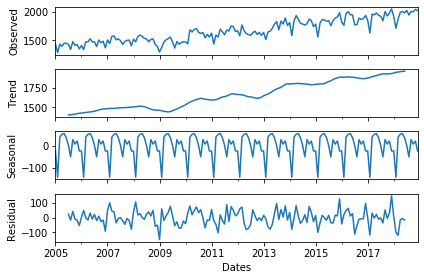

In [25]:
sd_result.plot();

It's clear this data is not stationary, so no need to do an Augmented Dickey-Fuller test at this stage. Clear trend and seasonality elements to the historical series. Lets plot out a quick seasonal chart of the last few years for clarity..

In [77]:
# Arrange underlying data
raw_seas_data = global_demand[['WM M']]['20130101':].reset_index(level=0)
formatted_seas_data = raw_seas_data.set_index([raw_seas_data['Dates'].dt.month, raw_seas_data['Dates'].dt.year])['WM M'].unstack()
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

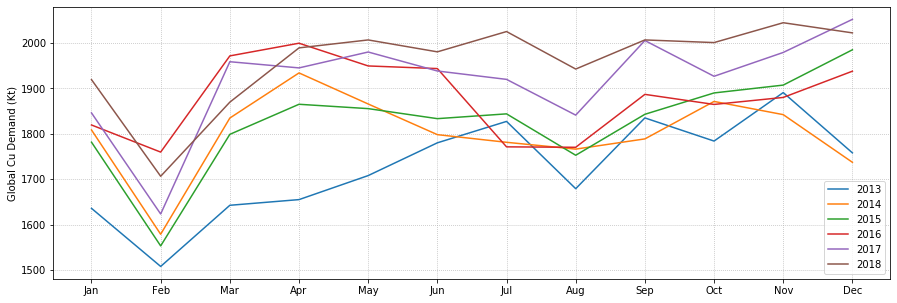

In [76]:
# Plot seasonal chart
formatted_seas_data = formatted_seas_data.iloc[:, ::-1]
fig = plt.figure(figsize=(15, 5))
ax1 = plt.subplot2grid((1,1), (0, 0))
for col in formatted_seas_data.columns:
    ax1.plot(months, formatted_seas_data[col].values, label=col)
ax1.set_ylabel('Global Cu Demand (Kt)')
ax1.legend()
ax1.grid(linestyle=':', linewidth=0.75)
plt.plot();